In [1]:
import os
import numpy as np
os.environ['NOTEBOOK_MODE'] = '1'
from robustness.tools.vis_tools import show_image_row

from viz_utils import *
from utils import *

In [2]:
class_index = 325
feature_index = 595
IMAGENET_PATH = 'SPECIFY IMAGENET PATH HERE (THE FINAL FOLDER SHOULD BE ILSVRC2012/)'

grouping = 'prediction' # can be either: label, prediction, default (used in paper is prediction)

=> loading checkpoint './models/robust_resnet50.pth'
=> loaded checkpoint './models/robust_resnet50.pth' (epoch 105)


/scratch1/ssingla/miniconda3/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448238472/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


****************************************** Visualization of feature: 595 ******************************************


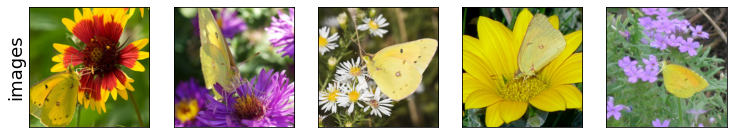

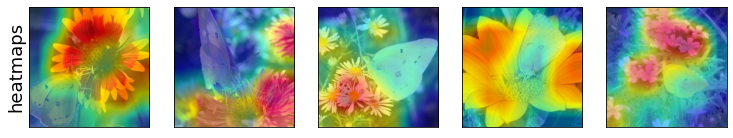

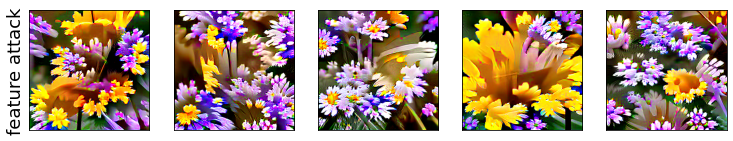

******************************************** Description of class: 325 ********************************************
Object name(s): sulphur butterfly, sulfur butterfly
Object supercategory: inverterbrates
Object definition: any of numerous yellow or orange butterflies
Object wikipedia link(s): https://en.wikipedia.org/wiki/Coliadinae
Object images from ImageNet validation set:


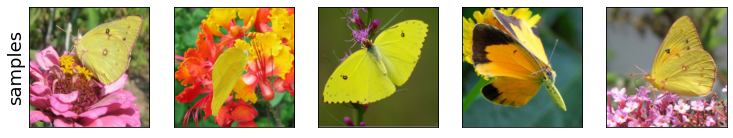

********************************************** MTurk Worker answers ***********************************************
Format => Answer by worker {worker_id}: {main_answer}, {confidence}, {reasons}

Answer by worker 150 : separate_object, 5, The focus is on a flower and not the main object which is a butterfly.
Answer by worker 185 : separate_object, 3, Red focus is on the flowers.
Answer by worker 186 : separate_object, 5, Focus is not  set on main object butterfly .
Answer by worker 125 : background, 4, The red region in the Highlighted visual attributes focuses on the background of a sulphur butterfly.
Answer by worker 124 : background, 5, The focus in first two images is on the sulphur butterflyand in third the focus is on the background of an sulphur butterflyand.

Final annotation: spurious, votes for core: 0, votes for spurious: 5


In [3]:
if grouping == 'label':
    train_labels = np.load('metadata/train_labels.npy')
    all_indices = np.nonzero(train_labels == class_index)[0]
elif grouping == 'prediction':
    train_preds = np.load('metadata/train_preds.npy')
    all_indices = np.nonzero(train_preds == class_index)[0]
else:
    raise ValueError('Unknown grouping: {:s}. Must be either: prediction/label.'.format(grouping))
    
imagenet_subset = ImageNetSubset(IMAGENET_PATH, all_indices)

robust_model = load_robust_model(IMAGENET_PATH)
features = generate_features(robust_model, imagenet_subset, batch_size=64)

sorted_indices = np.argsort(-features[:, feature_index])
max_5_indices = sorted_indices[:5]

images, heatmaps, feature_attacks = create_images(max_5_indices, feature_index, imagenet_subset, robust_model)

print_with_stars(' Visualization of feature: {:d} '.format(feature_index))
show_image_row([images], ['images'], tlist=[], fontsize=18)
show_image_row([heatmaps], ['heatmaps'], tlist=[], fontsize=18)
show_image_row([feature_attacks], ['feature attack'], tlist=[], fontsize=18)

print_with_stars(' Description of class: {:d} '.format(class_index))

class_df = pd.read_csv('class_metadata.csv', index_col = 'class_index')
row = class_df.iloc[[class_index]].to_dict(orient='records')[0]
print('Object name(s): {:s}'.format(row['synset']))
print('Object supercategory: {:s}'.format(row['supercategory']))
print('Object definition: {:s}'.format(row['gloss']))

wikilinks = eval(row['wikilinks'])
wikilinks_str = ''
for wikilink in wikilinks:
    wikilinks_str += str(wikilink) + ', '
wikilinks_str = wikilinks_str[:-2]
print('Object wikipedia link(s): {:s}'.format(wikilinks_str))

print('Object images from ImageNet validation set:')
val_sample_paths = eval(row['val_sample_paths'])
wordnet_id = row['wordnet_id']
val_folder_path = os.path.join(IMAGENET_PATH, 'val', str(wordnet_id))
val_sample_images = load_images_fnames(val_sample_paths, val_folder_path)

show_image_row([val_sample_images], ['samples'], tlist=[], fontsize=18)


key = str(class_index) + '_' + str(feature_index)
csv_path = 'mturk_results/discover_spurious_features.csv'
mturk_results_discover = MTurk_Results(csv_path)
answers_dict = mturk_results_discover.answers_dict

core_votes = 0
spurious_votes = 0
if key in answers_dict:
    print_with_stars(' MTurk Worker answers ')    
    answers = answers_dict[key]
    print('Format => Answer by worker {worker_id}: {main_answer}, {confidence}, {reasons}\n')
    for answer in answers:
        worker_id, main_ans, conf, reasons = answer
        if main_ans == 'main_object':
            core_votes += 1
        else: 
            spurious_votes += 1
        print('Answer by worker {:d} : {:s}, {:d}, {:s}'.format(worker_id, main_ans, int(conf), reasons))

final_ans = 'core' if core_votes >= 3 else 'spurious'    
print('\nFinal annotation: {:s}, votes for core: {:d}, votes for spurious: {:d}'.format(
      final_ans, core_votes, spurious_votes))